# This notebook plots spatial predictions
This notebook reads in the prediction shapefiles, along with `.tif` images of isochore thicknesses for the two formations and plots them along with the surface geology exposures of the Eastern Greater Green River Basin.

In [1]:
import pandas as pd
import numpy as np
import verde as vd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
import rasterio.plot
import matplotlib as mpl
from descartes import PolygonPatch
import rasterio.plot
import matplotlib.ticker as tkr
import geopandas as gpd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns; sns.set()
sns.set_style('darkgrid', {'legend.frameon':True})
%matplotlib inline

In [2]:
def func(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}'.format(int(x))
    return s
tfuwells = gpd.read_file(r"predictions\ftunion_KNN_predictions_prob.shp")
klawells = gpd.read_file(r"predictions\lance_KNN_predictions_prob.shp")
lance = gpd.read_file(r'base_data\shapefiles\lance_outcrop.shp')
ftun = gpd.read_file(r'base_data\shapefiles\ftunion_outcrop.shp')
faults = gpd.read_file(r'base_data\shapefiles\simp_faults.shp')
sections = gpd.read_file(r'base_data\shapefiles\crossection.shp',)

In [3]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rasterio.open(r'base_data\lance2864.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(r'base_data\lance2864_reproject.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
with rasterio.open(r'base_data\ftunion2864.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(r'base_data\ftunion2864_reproject.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [4]:
fu = rasterio.open(r"base_data\ftunion2864_reproject.tif")
la = rasterio.open(r"base_data\lance2864_reproject.tif")

In [5]:
%%capture
tfuwells = tfuwells.to_crs('epsg:4326')
klawells = klawells.to_crs('epsg:4326')
lance = lance.to_crs('epsg:4326')
ftun = ftun.to_crs('epsg:4326')
faults = faults.to_crs('epsg:4326')
sections = sections.to_crs('epsg:4326')

In [6]:
truncation_color = '#ffffbf'
onlap_color = '#2c7bb6'
horiz_color = '#d7191c'

truncCmap = LinearSegmentedColormap.from_list('mycmap', [onlap_color, truncation_color])
onlapCmap = LinearSegmentedColormap.from_list('mycmap', [truncation_color, onlap_color])
horizCmap = LinearSegmentedColormap.from_list('mycmap', [onlap_color, horiz_color])


In [7]:
fthoriz = tfuwells[(tfuwells.horiz_prob>0.)]
lahoriz = klawells[(klawells.horiz_prob>0.)]

Text(55.0, 0.5, 'Latitude')

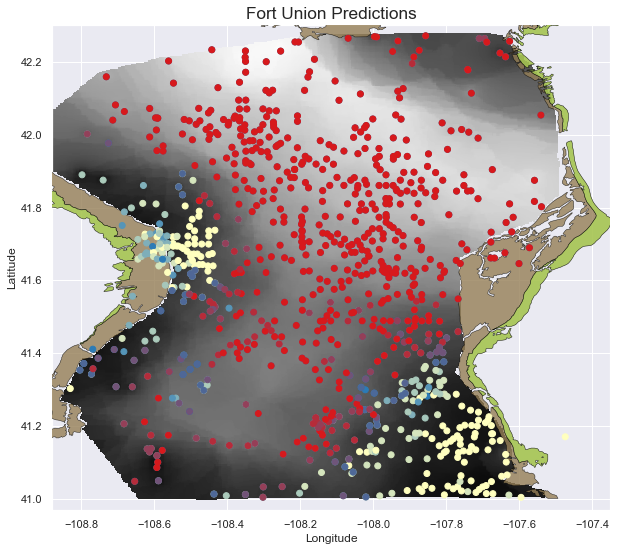

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(fu, ax=ax, cmap='gray', zorder=1)

tfuwells.plot(ax=ax, column='trunc_prob', cmap=truncCmap, vmin=0, vmax=1, zorder=4)
fthoriz.plot(ax=ax, column='horiz_prob', cmap=horizCmap, vmin=0, vmax=1, zorder=5)

kwarg2s = {'facecolor': '#957F56', 'edgecolor': 'black', 'linewidth': 0.5, 'hatch': ''}
ftun.plot(ax=ax, zorder=3, label='Fort Union Outcrop', alpha=0.8, **kwarg2s)
kwarg3s = {'facecolor': '#A6C551', 'edgecolor': 'black', 'linewidth': 0.5, 'hatch': ''}
lance.plot(ax=ax, **kwarg3s, zorder=3, alpha=0.9)

plt.title('Fort Union Predictions', size='xx-large')
plt.xlim(-108.88, -107.35)
plt.ylim(40.97, 42.3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('fortunion.pdf', bbox_inches='tight')

No handles with labels found to put in legend.


Text(55.0, 0.5, 'Northing (m)')

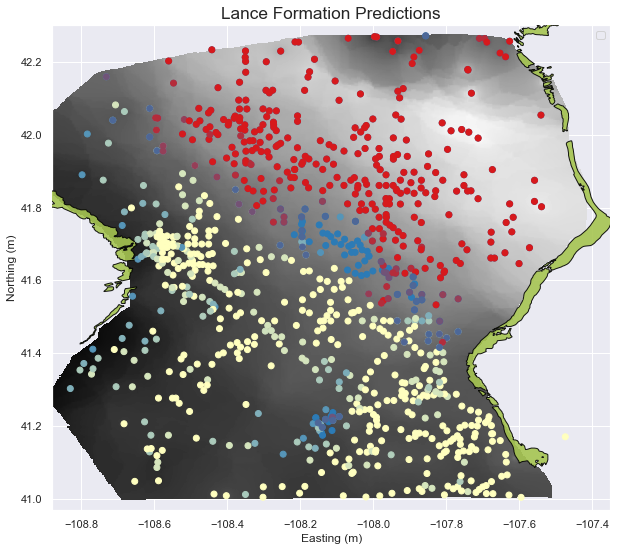

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(la, ax=ax, cmap='gray', zorder=1)

klawells.plot(ax=ax, column='trunc_prob', cmap=truncCmap, vmin=0, vmax=1, zorder=4)
lahoriz.plot(ax=ax, column='horiz_prob', cmap=horizCmap, vmin=0, vmax=1, zorder=5)
lance.plot(ax=ax, color='#A6C551', edgecolor='black', zorder=3, alpha=0.9)
plt.legend()
plt.title('Lance Formation Predictions', size='xx-large')
plt.xlim(-108.88, -107.35)
plt.ylim(40.97, 42.3)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
#plt.savefig('lance_prob.pdf', bbox_inches='tight')